Курс: "Машинное обучение"

Практическая работа 2: "Логистическая регрессия"

Выполнила: Блинова ЕМ, КЭ-128

В этой работе используется метод логистической регрессии для решения задач бинарной и множественной классификации. Строиттся граница решений. Наблюдается явление переобучения и используется регуляризация для борьбы с ним.

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import pread
import scipy.optimize as opt

from sklearn.preprocessing import PolynomialFeatures

In [2]:
# подключение к гугл-диску
from google.colab import drive
drive.mount('/content/drive')

file_path1 = '/content/drive/My Drive/Colab Notebooks/Dataset/ex2data1.txt'
file_path2 = '/content/drive/My Drive/Colab Notebooks/Dataset/ex2data2.txt'
file_path3 = '/content/drive/My Drive/Colab Notebooks/Dataset/ex2data3.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Бинарная классификация. Случай линейно разделимых классов

Задача определения шанса абитуриента поступить в институт
по известным результатам его двух экзаменов.

Для решения данной задачи бинарной классификации (не поступит-поступит) использвована логистическая регрессия.

Исходные данные - в файле ex2data1.txt

In [3]:
df1 = pd.read_csv(file_path1, delimiter=',', header=None, names=['Exam 1 Score', 'Exam 2 Score', 'Admitted'])
df1.head()

,Exam 1 Score,Exam 2 Score,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [4]:
# Преобразование данных в массивы numpy
X = df1[['Exam 1 Score', 'Exam 2 Score']].values
y = df1['Admitted'].values

In [5]:
X[:5], y[:5]

(array([[34.62365962, 78.02469282],
        [30.28671077, 43.89499752],
        [35.84740877, 72.90219803],
        [60.18259939, 86.3085521 ],
        [79.03273605, 75.34437644]]),
 array([0, 0, 0, 1, 1]))

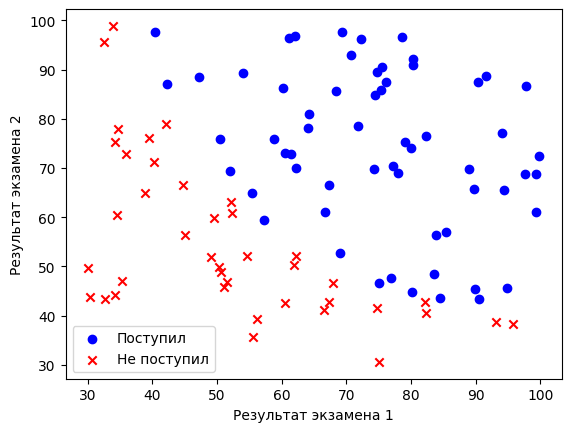

In [6]:
# Создание фигуры
fig, ax = plt.subplots()

# Отображение положительных и отрицательных примеров
pos = y == 1
neg = y == 0

ax.scatter(X[pos, 0], X[pos, 1], c='b', marker='o', label='Поступил')
ax.scatter(X[neg, 0], X[neg, 1], c='r', marker='x', label='Не поступил')

# Настройка графика
ax.set_xlabel('Результат экзамена 1')
ax.set_ylabel('Результат экзамена 2')
ax.legend()
plt.show()

## Подготовка данных для дальнейшего обучения

In [7]:
# Добавление столбца единиц к X
X = np.hstack((np.ones((X.shape[0], 1)), X))
# Инициализация нулевых начальных значений для параметров
initial_theta = np.zeros(X.shape[1])

In [8]:
X[:5], y[:5], initial_theta

(array([[ 1.        , 34.62365962, 78.02469282],
        [ 1.        , 30.28671077, 43.89499752],
        [ 1.        , 35.84740877, 72.90219803],
        [ 1.        , 60.18259939, 86.3085521 ],
        [ 1.        , 79.03273605, 75.34437644]]),
 array([0, 0, 0, 1, 1]),
 array([0., 0., 0.]))

## Функции (без регуляризации)

Функция сигмоиды:

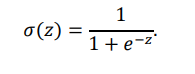


In [9]:
# Функция сигмоиды
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
# Функция стоимости
def costFunction(theta, X, y):
    m = len(y)  # количество обучающих примеров
    h = sigmoid(np.dot(X, theta))  # гипотеза модели
    epsilon = 1e-5  # небольшое значение для предотвращения логарифма нуля
    J = (-1/m) * (np.dot(y, np.log(h + epsilon)) + np.dot((1 - y), np.log(1 - h + epsilon)))
    return J

In [11]:
# Функция градиента
def gradientFunc(theta, X, y):
    m = len(y)  # количество обучающих примеров
    h = sigmoid(np.dot(X, theta))  # гипотеза модели
    gradient = (1/m) * np.dot(X.T, (h - y))
    return gradient

## Вызов функций

In [12]:
# Пример использования функции стоимости
cost = costFunction(initial_theta, X, y)
print(f'Значение целевой функции для начальных параметров: {cost}')

Значение целевой функции для начальных параметров: 0.6931271807599428


In [13]:
# Пример использования функции градиента
grad = gradientFunc(initial_theta, X, y)
print(f'Значение градиента для начальных параметров: {grad}')

Значение градиента для начальных параметров: [ -0.1        -12.00921659 -11.26284221]


In [14]:
# Минимизация целевой функции
result = opt.fmin_tnc(func=costFunction, x0=initial_theta, fprime=gradientFunc, args=(X, y))
theta_optimized = result[0]
print(f'Оптимальные значения параметров: {theta_optimized}')

Оптимальные значения параметров: [-25.16131857   0.20623159   0.20147149]


## Построение границы решений

In [15]:
# Функция для отображения данных
def plot_data(X, y):
    fig, ax = plt.subplots()
    pos = y == 1
    neg = y == 0
    ax.scatter(X[pos, 0], X[pos, 1], c='b', marker='o', label='Поступил')
    ax.scatter(X[neg, 0], X[neg, 1], c='r', marker='x', label='Не поступил')
    ax.set_xlabel('Результат экзамена 1')
    ax.set_ylabel('Результат экзамена 2')
    ax.legend()

In [16]:
# Построение границы решения
def plotDecisionBoundary(theta, X, y):
    plot_data(X[:, 1:3], y)
    x_value = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
    y_value = -(theta[0] + theta[1] * x_value) / theta[2]
    plt.plot(x_value, y_value, 'g')
    plt.show()

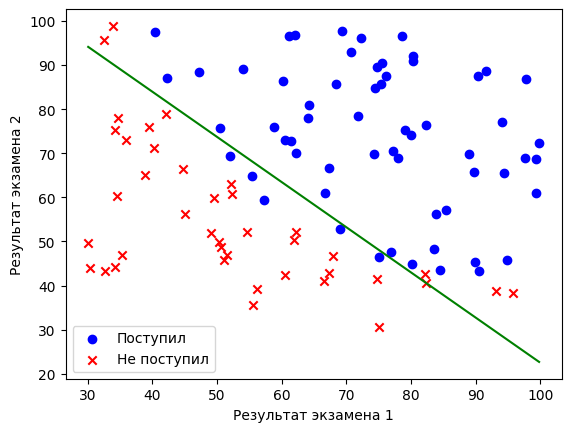

In [17]:
plotDecisionBoundary(theta_optimized, X, y)

In [18]:
# Оценка вероятности поступления для студента с баллами 45 и 85
student_scores = np.array([1, 45, 85])
probability = sigmoid(np.dot(student_scores, theta_optimized))
print(f'Вероятность поступления для студента с баллами 45 и 85: {probability * 100:.2f}%')

Вероятность поступления для студента с баллами 45 и 85: 77.63%


## Оценка точности модели

In [19]:
# Оценка точности классификатора
def predict(theta, X):
    probability = sigmoid(np.dot(X, theta))
    return probability >= 0.5

In [20]:
predictions = predict(theta_optimized, X)
accuracy = np.mean(predictions == y) * 100
print(f'Точность классификатора: {accuracy:.2f}%')

Точность классификатора: 89.00%


# 2. Бинарная классификация. Случай не разделимых линейно классов


Классы не являются линейно разделимыми. Даны результаты двух тестов микрочипов, по которым необходимо решить, бракованные они или стандартные, принимаются они или отклоняются.

Исходные данные - в файле ex2data2.txt


## Визуализация данных

In [21]:
df2 = pd.read_csv(file_path2, delimiter=',', header=None, names=['Microchip Test 1', 'Microchip Test 2', 'Accepted'])
df2.head()

,Microchip Test 1,Microchip Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [22]:
X2 = df2[['Microchip Test 1', 'Microchip Test 2']].values
y2 = df2['Accepted'].values

In [23]:
# Функция для отображения данных
def plot_data2(X, y):
    fig, ax = plt.subplots()
    pos = y == 1
    neg = y == 0
    ax.scatter(X[pos, 0], X[pos, 1], c='b', marker='+', label='Accepted')
    ax.scatter(X[neg, 0], X[neg, 1], c='k', marker='d', label='Rejected')
    ax.set_xlabel('Microchip Test 1')
    ax.set_ylabel('Microchip Test 2')
    ax.legend()

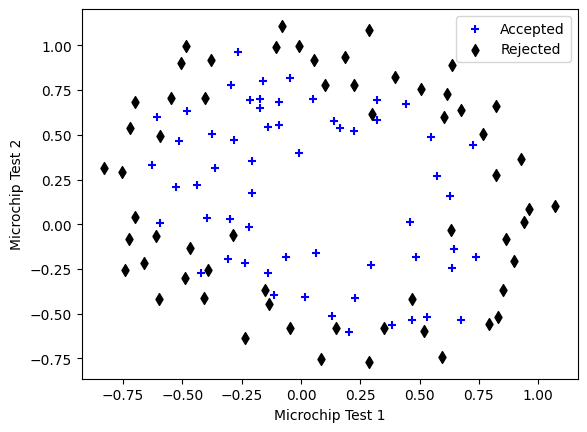

In [24]:
plot_data2(X2, y2)
plt.show()

## Добавление входных признаков

In [25]:
# Добавление полиномиальных признаков до 6-й степени
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X2)

## Функции (с регуляризацией)

Новый вектор признаков

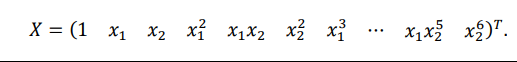

Целевая функция

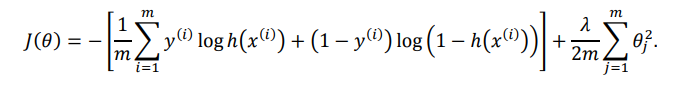

Граница решений для деления классов

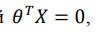

In [26]:
# Функция стоимости с регуляризацией
def costFunctionR(theta, X, y, lam):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-5
    J = (-1/m) * (np.dot(y, np.log(h + epsilon)) + np.dot((1 - y), np.log(1 - h + epsilon))) + (lam / (2 * m)) * np.sum(np.square(theta[1:]))
    return J

In [27]:
# Функция градиента с регуляризацией
def gradientFuncR(theta, X, y, lam):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    gradient = (1/m) * np.dot(X.T, (h - y))
    gradient[1:] += (lam / m) * theta[1:]
    return gradient

## Запуск функций

In [28]:
# Инициализация нулевых начальных значений для параметров
initial_theta2 = np.zeros(X_poly.shape[1])
lambda2_ = 1

# Пример использования функции стоимости и градиента с регуляризацией
cost2 = costFunctionR(initial_theta2, X_poly, y2, lambda2_)
grad2 = gradientFuncR(initial_theta2, X_poly, y2, lambda2_)
print(f'Значение целевой функции для начальных параметров: {cost2}')
print(f'Значение градиента для начальных параметров: {grad2}')

Значение целевой функции для начальных параметров: 0.6931271807599428
Значение градиента для начальных параметров: [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]


In [29]:
# Минимизация целевой функции с регуляризацией
result2 = opt.fmin_tnc(func=costFunctionR, x0=initial_theta2, fprime=gradientFuncR, args=(X_poly, y2, lambda2_))
theta_optimized = result2[0]
print(f'Оптимальные значения параметров с регуляризацией: {theta_optimized}')

Оптимальные значения параметров с регуляризацией: [ 1.27271027  0.62529964  1.18111686 -2.01987398 -0.9174319  -1.43166928
  0.12393227 -0.36553118 -0.35725403 -0.17516291 -1.45817009 -0.05098417
 -0.61558552 -0.27469165 -1.19271298 -0.2421784  -0.20603297 -0.04466178
 -0.27778953 -0.29539513 -0.45645982 -1.04319155  0.02779373 -0.29244873
  0.01555761 -0.32742406 -0.14389151 -0.92467487]


## Построение границы решений

In [30]:
# Функция для отображения данных
def plot_data3(X, y):
    fig, ax = plt.subplots()
    pos = y == 1
    neg = y == 0
    ax.scatter(X[pos, 0], X[pos, 1], c='b', marker='+', label='Accepted')
    ax.scatter(X[neg, 0], X[neg, 1], c='k', marker='d', label='Rejected')
    ax.set_xlabel('Microchip Test 1')
    ax.set_ylabel('Microchip Test 2')
    ax.legend()

In [31]:
# Построение границы решения
def plotDecisionBoundary2(theta, X, y):
    plot_data3(X, y)
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros((len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            z[i, j] = np.dot(poly.fit_transform(np.array([[u[i], v[j]]])), theta).item()
    z = z.T
    plt.contour(u, v, z, levels=[0], colors='g')
    plt.show()

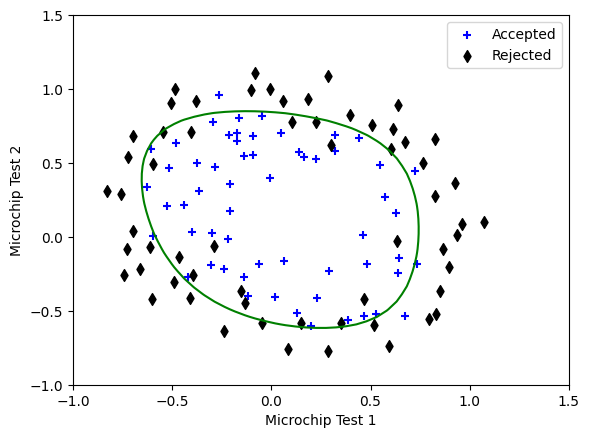

In [32]:
plotDecisionBoundary2(theta_optimized, X2, y2)

## Явления недообучения и переобучения

Оптимальные значения параметров с регуляризацией (lambda = 0): [   16.33745589    23.18534961     4.95856572  -173.21220139
   -96.14158403   -71.06187608  -186.10104025  -114.98005591
   -58.13916872    10.01483996   622.19804639   566.29880329
   701.77235685   307.26473318    94.85968976   336.34489538
   379.71959294   411.99277902   181.89822839    49.91324065
    -6.93553646  -737.08792117  -910.8216709  -1294.28901486
  -942.69501101  -825.96427843  -321.44528306   -58.21672396]


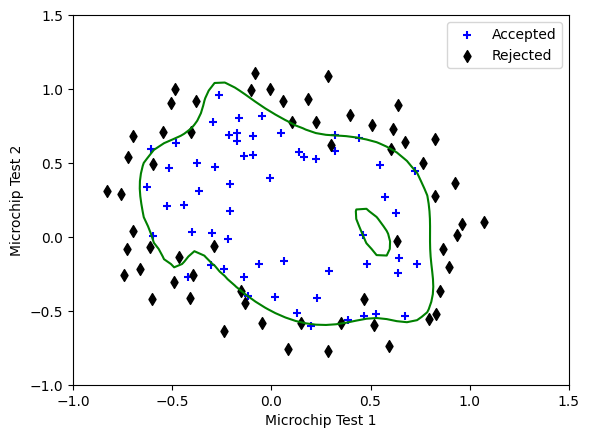

Оптимальные значения параметров с регуляризацией (lambda = 1): [ 1.27271027  0.62529964  1.18111686 -2.01987398 -0.9174319  -1.43166928
  0.12393227 -0.36553118 -0.35725403 -0.17516291 -1.45817009 -0.05098417
 -0.61558552 -0.27469165 -1.19271298 -0.2421784  -0.20603297 -0.04466178
 -0.27778953 -0.29539513 -0.45645982 -1.04319155  0.02779373 -0.29244873
  0.01555761 -0.32742406 -0.14389151 -0.92467487]


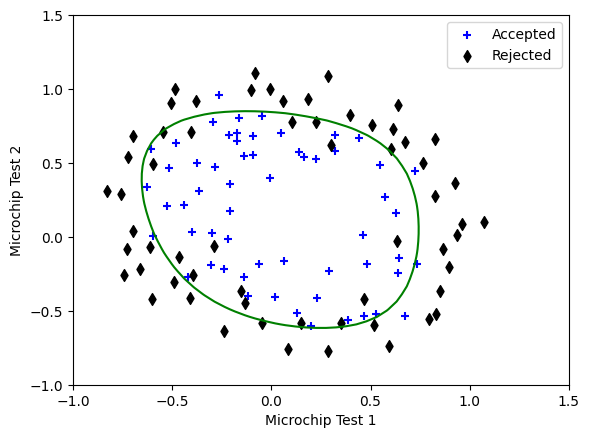

Оптимальные значения параметров с регуляризацией (lambda = 100): [ 0.02187847 -0.0174817   0.00571065 -0.05516901 -0.01314874 -0.03859873
 -0.01846356 -0.00773219 -0.00892429 -0.02280461 -0.04343846 -0.00235623
 -0.01415612 -0.00349507 -0.04143595 -0.02100593 -0.00471917 -0.00359131
 -0.00632226 -0.0050244  -0.03197683 -0.03416334 -0.00107629 -0.00702615
 -0.00038507 -0.0079823  -0.00154779 -0.04108683]


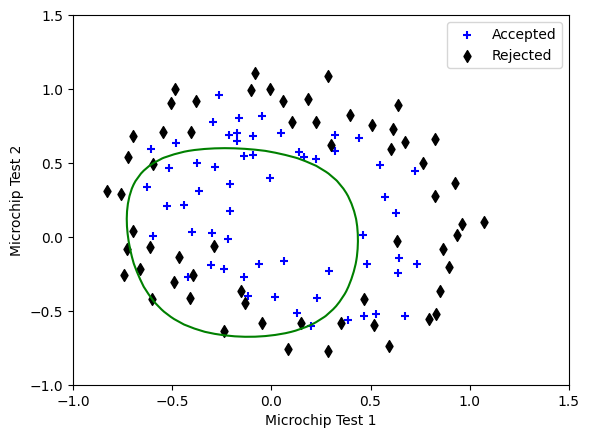

In [33]:
# Минимизация целевой функции с регуляризацией для разных значений lambda
lambda_values = [0, 1, 100]
for lambda_ in lambda_values:
    result = opt.fmin_tnc(func=costFunctionR, x0=initial_theta2, fprime=gradientFuncR, args=(X_poly, y2, lambda_))
    theta_optimized = result[0]
    print(f'Оптимальные значения параметров с регуляризацией (lambda = {lambda_}): {theta_optimized}')
    plotDecisionBoundary2(theta_optimized, X2, y2)

- Явление переобучения (рисунок 1): модель сложная и запоминает обучающие данные, включая шум и колебания. Хорошая производительность на обучающих данных, но высокая ошибка на тестовом наборе данных.  Полиномиальная модель высокой степени пытается предсказать слишком сложную границу решений. При этом оптимальные значения параметра модели имеют очень высокие значения (модель подгоняет данные). Регуляризация же должна накладывать штрафные значения параметров.

- Явление недобучения (рисунок 3): модель не захватывает сложные зависимости данных. Высокая ошибка на обучающем и тестовом наборах данных. Полиномиальная модель высокой степени не захватила сложные зависимости данных. Граница решений в данном случае сильно не соответствует данным. При этом оптимальные значения параметров модели имеют очень малы - модель слишком сильно регуляризована, что привело к недообучению.

## Эксперимент по борьбе с недообучением и переобучением

- Чтобы избежать переобучения: можно уменьшить степень полинома и увеличить объем данных.
- Чтобы избежать недообучения: можно увеличить сложность модели (с помощью искусственно вводимых признаков) и увеличения объема данных.

Значение целевой функции для начальных параметров: 0.6931271807599428
Значение градиента для начальных параметров: [ 8.47457627e-03  1.87880932e-02  7.77711864e-05  5.03446395e-02
  1.15013308e-02  3.76648474e-02  1.83559872e-02  7.32393391e-03
  8.19244468e-03  2.34764889e-02  3.93486234e-02  2.23923907e-03
  1.28600503e-02  3.09593720e-03  3.93028171e-02  1.99707467e-02
  4.32983232e-03  3.38643902e-03  5.83822078e-03  4.47629067e-03
  3.10079849e-02  3.10312442e-02  1.09740238e-03  6.31570797e-03
  4.08503006e-04  7.26504316e-03  1.37646175e-03  3.87936363e-02
  1.99427086e-02  2.74239681e-03  2.32500787e-03  2.21859968e-03
  1.37054473e-03  4.59059364e-03  2.44887343e-03  3.45775396e-02
  2.58470812e-02  9.24073316e-04  3.56449986e-03  2.36431492e-04
  2.73345994e-03  1.41372690e-04  5.06220460e-03  7.44299593e-04
  3.91158180e-02  1.94460178e-02  2.03971305e-03  1.67313910e-03
  9.57374855e-04  8.28510751e-04  1.45754709e-03  5.55440822e-04
  3.80878101e-03  1.42922173e-03  3.7440

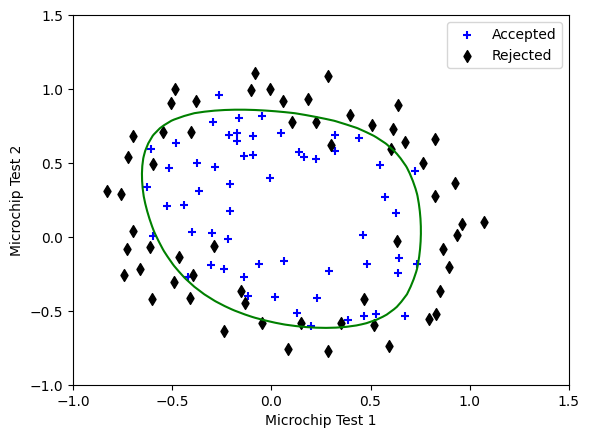

In [34]:
#уменьшение сложности модели: полиномиальный признак 3-й степени и увеличение лямбда до 100
X2 = df2[['Microchip Test 1', 'Microchip Test 2']].values
y2 = df2['Accepted'].values

# Добавление полиномиальных признаков до 3-й степени
poly = PolynomialFeatures(15)
X_poly = poly.fit_transform(X2)



# Инициализация нулевых начальных значений для параметров
initial_theta2 = np.zeros(X_poly.shape[1])
lambda2_ = 1

# Пример использования функции стоимости и градиента с регуляризацией
cost2 = costFunctionR(initial_theta2, X_poly, y2, lambda2_)
grad2 = gradientFuncR(initial_theta2, X_poly, y2, lambda2_)
print(f'Значение целевой функции для начальных параметров: {cost2}')
print(f'Значение градиента для начальных параметров: {grad2}')

# Минимизация целевой функции с регуляризацией
result2 = opt.fmin_tnc(func=costFunctionR, x0=initial_theta2, fprime=gradientFuncR, args=(X_poly, y2, lambda2_))
theta_optimized = result2[0]
print(f'Оптимальные значения параметров с регуляризацией: {theta_optimized}')


# Построение границы решения
plotDecisionBoundary2(theta_optimized, X2, y2)

lambda2_ = 0 и poly = PolynomialFeatures(3)

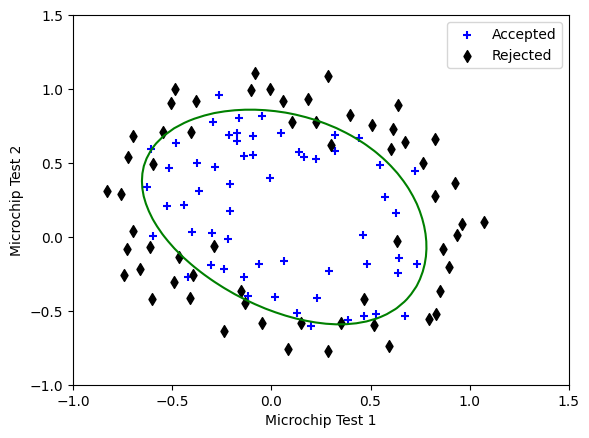

lambda2_ = 0.5 и poly = PolynomialFeatures(2)

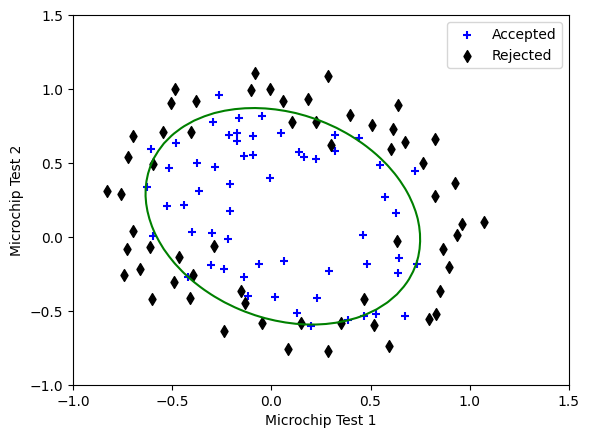

lambda2_ = 1 и poly = PolynomialFeatures(15)

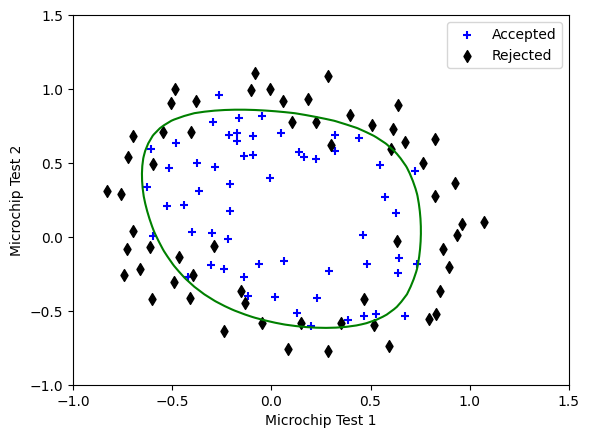

lambda2_ = 0 и poly = PolynomialFeatures(10)

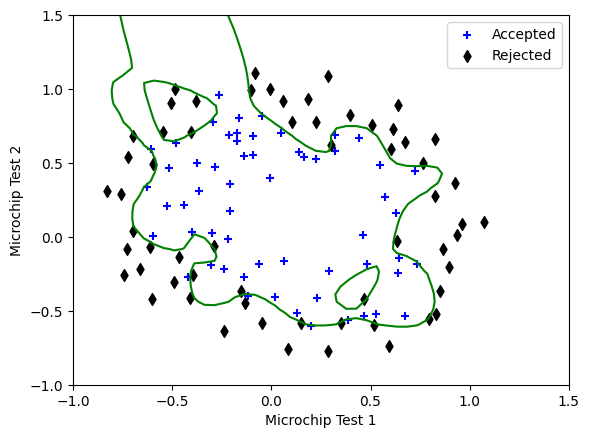

# 3. Использование логистической регрессии для решения задачи множественной классификации – распознавания рукописных цифр от 0 до 9

В этой задаче решается задача классификации рукописных цифр от 0 до 9 с
помощью множественной логистической регрессии, а точнее метода one-vs-all.
Идея этого метода очень проста. Если есть объекты К классов, то строим К
различных бинарных классификатора, которые объекты определенного класса отделяют
от всех остальных. Т.е. первый классификатор отделяет объекты первого класса от всех
прочих ("не первого" класса), второй – второго и т.д. С помощью классификаторов для любого нового объекта вычисляется вероятность его
принадлежности к каждому из этих классов и выбрать тот класс, для которого это
значение оказалось наибольшим.
В этой работе набор данных содержит объекты 10 классов – это рукописные цифры от 0
до 9. Осуществляется обучение 10 различных бинарных классификаторов.

## Изучение исходного набора данных

In [35]:
df3 = pd.read_csv(file_path3, delimiter=',', header=None)
df3

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


Набор данных содержит 5000 рукописных цифр. Каждая цифра была изначально gray scale
картинкой 20х20 пикселей, которую затем "развернули" в строку из 400 элементов со
значениями, характеризующими интенсивность данного пикселя.

In [36]:
# Отделение признаков (X) и меток классов (y)
X3 = df3.iloc[:, :-1]  # Все столбцы, кроме последнего
y3 = df3.iloc[:, -1]   # Последний столбец

X3.head(), y3.head()

(   0    1    2    3    4    5    6    7    8    9    ...  390  391  392  393  \
 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
 1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
 2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
 3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
 4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
 
    394  395  396  397  398  399  
 0  0.0  0.0  0.0  0.0  0.0  0.0  
 1  0.0  0.0  0.0  0.0  0.0  0.0  
 2  0.0  0.0  0.0  0.0  0.0  0.0  
 3  0.0  0.0  0.0  0.0  0.0  0.0  
 4  0.0  0.0  0.0  0.0  0.0  0.0  
 
 [5 rows x 400 columns],
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: 400, dtype: float64)

In [37]:
# Добавление столбца из единиц к массиву X
X3 = np.hstack([np.ones((X3.shape[0], 1)), X3])
X3[:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

Построение бинарных классификаторов

Функции: sigmoid, costFunction, gradientFunc -- взяты из прошлой работы

In [44]:
# Инициализация матрицы для хранения оптимальных значений theta
all_theta = np.zeros((10, X3.shape[1]))

# Оптимизация для каждого класса
for k in range(10):
    # Создание бинарного вектора меток для текущего класса
    y_k = np.where(y3 == k, 1, 0)

    # Инициализация параметров theta
    initial_theta = np.zeros(X3.shape[1])

    # Оптимизация
    result = opt.fmin_tnc(func=costFunction, x0=initial_theta, fprime=gradientFunc, args=(X3, y_k))
    all_theta[k, :] = result[0]


all_theta

<ipython-input-9-aec0ca4bd0ce>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


array([[-5.93570873e+01,  0.00000000e+00,  0.00000000e+00, ...,
         7.95768163e-05,  1.10923855e-04,  0.00000000e+00],
       [-1.12298884e+01,  0.00000000e+00,  0.00000000e+00, ...,
         7.05606289e-02,  2.79158295e-07,  0.00000000e+00],
       [-4.28842821e+02,  0.00000000e+00,  0.00000000e+00, ...,
         1.09633227e+02, -8.79093026e-02,  0.00000000e+00],
       ...,
       [-1.66763584e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -1.45970688e+01,  1.68636734e+00,  0.00000000e+00],
       [-1.34862199e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -1.07036476e+01,  1.23606484e+00,  0.00000000e+00],
       [-8.73692703e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.71385104e-01,  9.46882809e-03,  0.00000000e+00]])

In [42]:
# Вычисление выходных значений каждого из 10 классификаторов
h = sigmoid(np.dot(X3, all_theta.T))  # Размер (5000, 10)

# Выбор класса с максимальным значением вероятности
h_argmax = np.argmax(h, axis=1)

# Вычисление доли правильных ответов
accuracy = np.mean(h_argmax == y3) * 100

# Вывод доли правильных ответов
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 99.12%


<ipython-input-9-aec0ca4bd0ce>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [43]:
# Выбор одного вектора из датасета
index = 4995
X_single = X3[index, :].reshape(1, -1)
y_single = y3[index]

# Вычисление выходных значений классификатора для выбранного вектора
h_single = sigmoid(np.dot(X_single, all_theta.T))
predicted_class = np.argmax(h_single, axis=1)[0]

# Вывод результата классификатора и исходной цифры
print(f'Predicted class: {predicted_class}')
print(f'Original class: {y_single}')

Predicted class: 9
Original class: 9.0


<ipython-input-9-aec0ca4bd0ce>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
